 # Project 7 - Implémentation d'un Modèle de Scoring
 
## Part 2 of XX - Entraînement des Modèles

# 1. Kaggle Resources

**Data:**
* https://www.kaggle.com/c/home-credit-default-risk/data

**Series of Notebooks detailing the Problem:**
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
* ...

**EDA:**
* https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda

**Feature Engineering:**
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

**Models/Scripts - Light_GBM**
* https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
* https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm

**DNN:**
https://www.kaggle.com/shep312/deep-learning-in-tf-with-upsampling-lb-758

# 2. Imports Bibliothèques

In [63]:
import os, re, gc

import pandas as pd
import numpy as np

In [64]:
import sys
import win32com.client 

In [65]:
import shap
import joblib

In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss, f1_score, balanced_accuracy_score 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [67]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier

# 3. Fonctions

## 3.0 Import des Données

In [69]:
def get_shortcut_path(filepath):
    shell = win32com.client.Dispatch("WScript.Shell")
    shortcut = shell.CreateShortCut(filepath)
    return shortcut.Targetpath +'\\'

## 3.1 Transformers

In [70]:
infinity_transformer = FunctionTransformer(lambda x : x.replace(np.inf, np.nan).replace(-np.inf, np.nan),check_inverse = False)

logscale_transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = False)
log1pscale_transformer = FunctionTransformer(np.log1p, inverse_func = np.expm1, check_inverse = False)

## 3.2 GridSearch

In [71]:
def gridsearch_evaluation(X_train, y_train, pipeline, param_grid, refit= None, scoring= None, **kwargs) :
    
    grid = GridSearchCV(pipeline, param_grid, refit=refit, scoring=scoring, **kwargs)
                        
    grid.fit(X_train, np.ravel((y_train)))
    
    eval_dict = {}
    test_scoring_dict ={}
    train_scoring_dict = {}
    if refit and scoring:
        for i in scoring :
            test_scoring_dict[i] = (grid.cv_results_["mean_test_" + i][grid.best_index_], 
                                    grid.cv_results_["std_test_" + i][grid.best_index_])
            train_scoring_dict[i] = (grid.cv_results_["mean_train_" + i][grid.best_index_], 
                                     grid.cv_results_["std_train_" + i][grid.best_index_])

        train_time = (grid.cv_results_["mean_fit_time"][grid.best_index_],
                      grid.cv_results_["std_fit_time"][grid.best_index_])

        eval_dict = {'estimator' : grid.best_estimator_,
                     'eval_method' : 'grid',
                     'best_grid_params' : grid.best_params_,
                     'train_scores' : train_scoring_dict, 
                     'test_scores' : test_scoring_dict, 
                     'train_time' : train_time }

    return eval_dict

In [72]:
def output_evaluation(model_name):
    ''' Function that outputs/prints the information from the dictionnary that collects the data from 
    the cross_validate or gridseach'''
    print(f"Model: {model_name}")
    print(50*"_")

    key = model_name
    print()
    print(50*"-")
    if model_dict[key]['eval_method'] == 'grid' :
        print("Les meilleurs parameters sont:")
        print(model_dict[key]['best_grid_params'])
        print()
    for (k1, l1), (k2, l2) in zip(model_dict[key]['train_scores'].items(), model_dict[key]['test_scores'].items()) :
        print(f"Le metric {k1} donne :")
        print(f"{l1[0]: .2f} +/- {l1[1]: .2f} pour le train sets")
        print(f"{l2[0]: .2f} +/- {l2[1]: .2f} pour le test sets")
        print(f"test score / train score :{(l1[0]/l2[0]) : 0.2f}")
        print()
    print(f"Le temps d'entrainement est {(1000 * model_dict[key]['train_time'][0]): .2f} +/-" + \
                                      f"{(1000 * model_dict[key]['train_time'][1]): .2f} ms.")
    print(50*"_")

## 3.3 Métrices, Collection et Affichage de Résultats

In [73]:
scoring_tple = ('neg_log_loss', 'roc_auc', 'balanced_accuracy', 'f1')

In [74]:
model_dict = {}

# 4. Import Données

In [75]:
PATH = os.getcwd()
DATAFOLDER = '\\DataShortcut.lnk'
filepath = get_shortcut_path(PATH+DATAFOLDER)
filename = 'data_processed.csv'

dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

In [76]:
y = dataset['TARGET']
X_id = dataset[['SK_ID_CURR']]
X = dataset.drop(columns=['TARGET', 'SK_ID_CURR'])
del dataset
gc.collect()

23671

# 5. Prétraitement

## 5.1 Supprimer des features peu peuplées

In [77]:
# Identify missing values above a given threshold
X = X.replace(np.inf, np.nan).replace(-np.inf, np.nan)
X_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
X_missing = X_missing.index[X_missing > 0.75]
#Drop the sparsely populated features
#X_red = X.drop(columns = X_missing)
print('There are %d columns with more than 75%% missing values' % len(X_missing))
print(f'After dropping these columns we are left with {len(X.drop(columns = X_missing).columns)} columns')

There are 32 columns with more than 75% missing values
After dropping these columns we are left with 741 columns


## 5.2 Classification des Features en Fonction de leur Distribution

**zero-one-features**
* des valeurs entre 0 et 1

**standard-features**
* des valeurs en dehors de la [0,1] 
* skew < 1
   
**log-features**
* des valeurs > 0
* skew >=1

**log1p-features**
* des valeurs >= 0
* skew >=1

In [83]:
to_be_scaled =  ((X.min() < 0) | (X.max() > 1))
to_be_scaled = [col for col in to_be_scaled[to_be_scaled == True].index.values if col not in X_missing]
zero_one_features = [col for col in X.columns if (col not in to_be_scaled) & (col not in X_missing)]
print(f"There are {len(zero_one_features)} features that have values  within the range of 0 and 1.\t -> 'zero_one_features'")
print(f"There are {len(to_be_scaled)} features that have values outside the range of 0 and 1.")

There are 327 features that have values  within the range of 0 and 1.	 -> 'zero_one_features'
There are 414 features that have values outside the range of 0 and 1.


In [84]:
#If the skew of the values is greater than 1, we will scale the features with either log or lop1p 
#and if necessary multiply by -1 beforehand
skewed = (X[to_be_scaled].skew() >= 1)
skewed = list(skewed[skewed == True].index.values)
standard_features = [col for col in to_be_scaled if col not in skewed]
print(f"Of the non 'zero_one_features' there are {len(standard_features)} features with skew  < 1.\t -> 'standard_features'")
print(f"Of the non 'zero_one_features' there are {len(skewed)} features with skew >= 1.")

Of the non 'zero_one_features' there are 92 features with skew  < 1.	 -> 'standard_features'
Of the non 'zero_one_features' there are 322 features with skew >= 1.


In [85]:
log_select = (X[skewed].min() > 0)
log_features = list(log_select[log_select == True].index.values)
log1p_select = (X[skewed].min() == 0)
log1p_features = list(log1p_select[log1p_select == True].index.values)
neg_log_select = (X[skewed].max() < 0)
neg_log_features = list(neg_log_select[neg_log_select == True].index.values)
neg_log1p_select = (X[skewed].max() == 0)
neg_log1p_features = list(neg_log1p_select[neg_log1p_select == True].index.values)
print(f"Of the non 'standard_features' there are {len(log_features)} features with min  > 0.\t -> 'log_features'")
print(f"Of the non 'standard_features' there are {len(log1p_features)} features with min == 0.\t -> 'lop1p_features'")
print(f"Of the non 'standard_features' there are {len(neg_log_features)} features with max  < 0.\t -> 'neg_log_features'")
print(f"Of the non 'standard_features' there are {len(neg_log1p_features)} features with max == 0.\t -> 'neg_lop1p_features'")

Of the non 'standard_features' there are 18 features with min  > 0.	 -> 'log_features'
Of the non 'standard_features' there are 263 features with min == 0.	 -> 'lop1p_features'
Of the non 'standard_features' there are 0 features with max  < 0.	 -> 'neg_log_features'
Of the non 'standard_features' there are 0 features with max == 0.	 -> 'neg_lop1p_features'


In [86]:
robustscale_features = [col for col in skewed if col not in log_features+log1p_features]
print(f"There are {len(robustscale_features)} non 'standard_features' that cannot easily \
be transformed to a logscale.\t -> 'robustscale_features'")

There are 41 non 'standard_features' that cannot easily be transformed to a logscale.	 -> 'robustscale_features'


### APPL_CNT_CHILDREN / APPL_CNT_FAM_MEMBERS

In [87]:
X['APPL_CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: APPL_CNT_CHILDREN, dtype: int64

In [88]:
select = X['APPL_CNT_CHILDREN'] >= 5
X.loc[select, 'APPL_CNT_CHILDREN'] = 5

In [89]:
select = X['APPL_CNT_FAM_MEMBERS'] >= 7
X.loc[select, 'APPL_CNT_FAM_MEMBERS'] = 7

# 6. Train/Test Dévision

In [90]:
test_size = 0.3
seed = 33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify=y)

# 7. Les Données Déséquilibrées (test des méthodes)

In [91]:
print(f"{len(X[y==1])} clients in the dataset defaulted, {len(X[y==0])} did not.")
print(f"That's {round(100*len(X[y==1])/len(X[y==0]), 2)}%.")

24825 clients in the dataset defaulted, 282686 did not.
That's 8.78%.


## 7.1 Sous-échantillonnage de la classe majoritaire

In [92]:
undersample = True
min_size = len(X_train[y_train==1])
if undersample :
    #undersample manually
    select = list(X_train[y_train==0].sample(min_size, random_state=22).index.values) + list(X_train[y_train==1].index.values)
    X_under = X_train.loc[select, :]
    y_under = y_train.loc[select]
    print(X_train.shape, X_under.shape, y_under.shape, min_size)
    #undersample with the module SMOTE
    rus = RandomUnderSampler(random_state=42)
    X_under, y_under = rus.fit_resample(X_train, y_train)
    print(X_train.shape, X_under.shape, y_under.shape, min_size)

(215257, 773) (34754, 773) (34754,) 17377
(215257, 773) (34754, 773) (34754,) 17377


In [93]:
#clear the memory
del X_under, y_under, rus
gc.collect()

8

## 7.2 Suréchantillonnage de la classe minoritaire avec me Module SMOTE

In [94]:
oversample = True
max_size = len(X_train[y_train==0])
if oversample :    
    #oversample with the module SMOTE
    imputer = SimpleImputer()
    X_imp = imputer.fit_transform(X_train)
    smote = SMOTE()
    X_over, y_over = smote.fit_resample(X_imp, y_train)
    print(X_train.shape, X_over.shape, y_over.shape, max_size)

(215257, 773) (395760, 773) (395760,) 197880


In [95]:
#clear the memory
del X_over, y_over, imputer, smote
gc.collect()

0

# 8. Le Préprocesseur (mise à l'échelle des features)

Le préprocesseur est concu d'une telle façon que s'il rencontre des colonnes/features inconnues, il va les simplement écarter (remainder = 'drop').

In [96]:
preprocessor = ColumnTransformer(transformers = [  
                                                 ('zero_one', 'passthrough', zero_one_features),
                                                 ('logscale', Pipeline([('log', logscale_transformer),
                                                                        ('standard', MinMaxScaler())]), 
                                                              log_features),
                                                 ('log1pscale', Pipeline([('log1p', log1pscale_transformer),
                                                                          ('standard', MinMaxScaler())]), 
                                                               log1p_features),
                                                 ('standardscale', MinMaxScaler(), standard_features),
                                                 ('robustscale', MinMaxScaler(), robustscale_features),
                                                         
                                                ], remainder = 'drop')

In [97]:
preprocessor

ColumnTransformer(transformers=[('zero_one', 'passthrough',
                                 ['APPL_NAME_CONTRACT_TYPE', 'APPL_CODE_GENDER',
                                  'APPL_FLAG_OWN_CAR', 'APPL_FLAG_OWN_REALTY',
                                  'APPL_REGION_POPULATION_RELATIVE',
                                  'APPL_FLAG_MOBIL', 'APPL_FLAG_EMP_PHONE',
                                  'APPL_FLAG_WORK_PHONE',
                                  'APPL_FLAG_CONT_MOBILE', 'APPL_FLAG_PHONE',
                                  'APPL_FLAG_EMAIL',
                                  'APPL_REG_REGION_NOT_LIVE_REGION',
                                  'APPL_REG_RE...
                                  'INSTAL_NEW_PAYMENT_DIFF_MAX',
                                  'BURO_DAYS_CREDIT_ENDDATE_MIN',
                                  'BURO_DAYS_CREDIT_ENDDATE_MAX',
                                  'BURO_DAYS_CREDIT_ENDDATE_MEAN',
                                  'BURO_AMT_CREDIT_SUM_DEBT_MAX

In [98]:
features_for_modeling = zero_one_features + log_features + log1p_features + standard_features + robustscale_features
selectfeatures = ColumnTransformer(transformers = [  
                                                   ('select', 'passthrough', features_for_modeling),
                                                  ], remainder = 'drop')

In [99]:
len(features_for_modeling)

741

# 9. Les Modèles

## 9.1 LogisticRegression - Version0

### 9.1.1 Paramètres du Modèle

In [100]:
modelname = 'LogRegr0'

In [101]:
pipeline = Pipeline([
                     ('selectfeatures', selectfeatures),
                     ('preprocessor', MinMaxScaler()),
                     ('imputer', SimpleImputer()),
                     ('model', LogisticRegression(tol=1e-2, solver='saga', warm_start=True)),
                    ])

In [102]:
param_grid = {'imputer__strategy' : ['median'],
              'model__class_weight' : ['balanced'],
              'model__C' : [2.5]}

### 9.1.2 GridSearch

In [103]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__C=2.5, model__class_weight=balanced; balanced_accuracy: (train=0.709, test=0.705) f1: (train=0.291, test=0.287) neg_log_loss: (train=-0.540, test=-0.543) roc_auc: (train=0.781, test=0.774) total time= 1.3min
[CV 2/5] END imputer__strategy=median, model__C=2.5, model__class_weight=balanced; balanced_accuracy: (train=0.712, test=0.706) f1: (train=0.281, test=0.277) neg_log_loss: (train=-0.577, test=-0.580) roc_auc: (train=0.781, test=0.776) total time= 1.2min
[CV 3/5] END imputer__strategy=median, model__C=2.5, model__class_weight=balanced; balanced_accuracy: (train=0.713, test=0.702) f1: (train=0.285, test=0.277) neg_log_loss: (train=-0.568, test=-0.573) roc_auc: (train=0.783, test=0.771) total time= 1.3min
[CV 4/5] END imputer__strategy=median, model__C=2.5, model__class_weight=balanced; balanced_accuracy: (train=0.711, test=0.701) f1: (train=0.270, test=0.265) neg_log_loss: (train=

In [104]:
model_dict[modelname] = eval_dict

In [ ]:
gc.collect()

### 9.1.3 Résultat

In [105]:
output_evaluation(modelname)

Model: LogRegr0
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 2.5, 'model__class_weight': 'balanced'}

Le metric neg_log_loss donne :
-0.58 +/-  0.03 pour le train sets
-0.58 +/-  0.02 pour le test sets
test score / train score : 0.99

Le metric roc_auc donne :
 0.78 +/-  0.00 pour le train sets
 0.77 +/-  0.00 pour le test sets
test score / train score : 1.01

Le metric balanced_accuracy donne :
 0.71 +/-  0.00 pour le train sets
 0.70 +/-  0.00 pour le test sets
test score / train score : 1.01

Le metric f1 donne :
 0.28 +/-  0.01 pour le train sets
 0.28 +/-  0.01 pour le test sets
test score / train score : 1.02

Le temps d'entrainement est  67897.77 +/- 6200.02 ms.
__________________________________________________


In [106]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

In [107]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5767457681017729
The ROC AUC score for the X_test set is		 0.7705035332046024
The bal. accuracy score for the X_test set is	 0.7040998282856636
The f1 score for the X_test set is		 0.27655499881948636


### 9.1.4 Export

In [108]:
export = True
if export:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    estimator = model_dict[modelname]['estimator']
    estimator.fit(X, y)
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

### 9.1.5 Re-Import du Modèle

In [ ]:
import_model = False
if import_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    modelname = 'LogRegr0'
    estimator = joblib.load(PATH + DATAFOLDER + modelname)

### 9.1.6 Importance des Features avec SHAP

In [109]:
len(estimator.named_steps['selectfeatures'].get_feature_names_out())

741

In [62]:
X.shape

(307511, 741)

In [60]:
np.char.lstrip(estimator.named_steps['selectfeatures'].get_feature_names_out().astype('str'), 'select__')

array(['APPL_NAME_CONTRACT_TYPE', 'APPL_CODE_GENDER', 'APPL_FLAG_OWN_CAR',
       'APPL_FLAG_OWN_REALTY', 'APPL_REGION_POPULATION_RELATIVE',
       'APPL_FLAG_MOBIL', 'APPL_FLAG_EMP_PHONE', 'APPL_FLAG_WORK_PHONE',
       'APPL_FLAG_CONT_MOBILE', 'APPL_FLAG_PHONE', 'APPL_FLAG_EMAIL',
       'APPL_REG_REGION_NOT_LIVE_REGION',
       'APPL_REG_REGION_NOT_WORK_REGION',
       'APPL_LIVE_REGION_NOT_WORK_REGION', 'APPL_REG_CITY_NOT_LIVE_CITY',
       'APPL_REG_CITY_NOT_WORK_CITY', 'APPL_LIVE_CITY_NOT_WORK_CITY',
       'APPL_EXT_SOURCE_1', 'APPL_EXT_SOURCE_2', 'APPL_EXT_SOURCE_3',
       'APPL_APARTMENTS_AVG', 'APPL_BASEMENTAREA_AVG',
       'APPL_YEARS_BEGINEXPLUATATION_AVG', 'APPL_YEARS_BUILD_AVG',
       'APPL_COMMONAREA_AVG', 'APPL_ELEVATORS_AVG', 'APPL_ENTRANCES_AVG',
       'APPL_FLOORSMAX_AVG', 'APPL_FLOORSMIN_AVG', 'APPL_LANDAREA_AVG',
       'APPL_LIVINGAPARTMENTS_AVG', 'APPL_LIVINGAREA_AVG',
       'APPL_NONLIVINGAPARTMENTS_AVG', 'APPL_NONLIVINGAREA_AVG',
       'APPL_APARTMENTS_MO

In [120]:
explainer = shap.Explainer(estimator.predict, X)

Permutation explainer: 32it [02:06,  4.36s/it]                                                                         


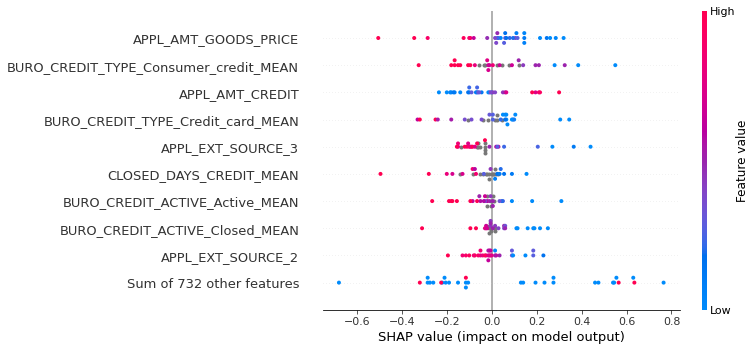

In [47]:
shap_values = explainer(X.sample(frac=0.0001), max_evals=2000)
shap.plots.beeswarm(shap_values)

In [123]:
explainer = shap.Explainer(estimator.predict, X)
sys.getsizeof(explainer)

48

In [138]:
print(explainer(X.sample(1), max_evals=2000).lower_bounds)

None


In [144]:
explainer.explain_row(np.array(X.sample(1)).ravel(), max_evals=2000, main_effects=None, error_bounds=None,
                                   batch_size=1, outputs=None, silent=False)

{'values': array([ 0.   ,  0.03 ,  0.055,  0.   ,  0.   ,  0.   , -0.005, -0.01 ,
         0.065,  0.   , -0.005,  0.   , -0.005,  0.   , -0.005, -0.01 ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ,
        -0.005,  0.01 ,  0.005,  0.   ,  0.   ,  0.   , -0.005,  0.005,
         0.   ,  0.01 ,  0.01 ,  0.12 ,  0.   , -0.005,  0.   ,  0.   ,
         0.   ,  0.   , -0.01 ,  0.   ,  0.01 ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.   , -0.005,
         0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ,
         0.   ,  0.005,  0.   ,  0.005,  0.01 ,  0.01 ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , -0.005,  0.01 ,  0.   ,  0.   ,  0.   ,  0.035,  0.   ,
         0.   ,  0.   ,  0.   , -0.01 ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   

In [111]:
export_explainer = True
if export_explainer:
    with open(PATH + DATAFOLDER + modelname+'_SHAP', "wb") as e:
        explainer.save(e)

In [86]:
imort_explainer = False
if imort_explainer:
    with open(PATH + '\\Data\\' + modelname+'_SHAP', "rb") as e:
        explainer = shap.Explainer.load(e)

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


## 9.2 LogisticRegression - Version1 (avec SMOTE)

### 9.2.1 Paramètres du Modèle

In [ ]:
modelname = 'LogRegr1'

In [39]:
pipeline = Pipeline([('preprocessor', MinMaxScaler()),
                     ('imputer', SimpleImputer()),
                     ('smote', SMOTE()),
                     ('model', LogisticRegression(tol=1e-2, solver='saga', warm_start=True))
                    ])

In [40]:
param_grid = {'imputer__strategy' : ['median'],
              'model__C' : [0.1, 1, 2.5, 5]}

### 9.2.2 GridSearch

In [41]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = ('neg_log_loss', 'roc_auc'),
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END imputer__strategy=median, model__C=0.1; neg_log_loss: (train=-0.550, test=-0.553) roc_auc: (train=0.763, test=0.758) total time=  54.4s
[CV 2/5] END imputer__strategy=median, model__C=0.1; neg_log_loss: (train=-0.549, test=-0.551) roc_auc: (train=0.763, test=0.759) total time=  56.4s
[CV 3/5] END imputer__strategy=median, model__C=0.1; neg_log_loss: (train=-0.549, test=-0.552) roc_auc: (train=0.764, test=0.756) total time=  54.5s
[CV 4/5] END imputer__strategy=median, model__C=0.1; neg_log_loss: (train=-0.547, test=-0.550) roc_auc: (train=0.765, test=0.753) total time=  54.7s
[CV 5/5] END imputer__strategy=median, model__C=0.1; neg_log_loss: (train=-0.549, test=-0.553) roc_auc: (train=0.765, test=0.752) total time=  53.1s
[CV 1/5] END imputer__strategy=median, model__C=1; neg_log_loss: (train=-0.547, test=-0.550) roc_auc: (train=0.767, test=0.760) total time= 1.8min
[CV 2/5] END imputer__strategy=median, model__C=

In [42]:
model_dict[modelname] = eval_dict

### 9.2.3 Résultat

In [43]:
output_evaluation(modelname)

Model: LogRegr1
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 5}

Le metric neg_log_loss donne :
-0.55 +/-  0.00 pour le train sets
-0.55 +/-  0.00 pour le test sets
test score / train score : 0.99

Le metric roc_auc donne :
 0.77 +/-  0.00 pour le train sets
 0.76 +/-  0.00 pour le test sets
test score / train score : 1.01

Le temps d'entrainement est  118407.62 +/- 9333.24 ms.
__________________________________________________


### 9.2.4 Export

In [ ]:
export = False
if export:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    estimator = model_dict[modelname]['estimator']
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

## 9.3 LogisticRegression - Version2 (avec un preprocessor customisé)

### 9.3.1 Paramètres du Modèle

In [ ]:
modelname = 'LogRegr2'

In [63]:
pipeline = Pipeline([
                     ('preprocessor', preprocessor),
                     ('imputer', SimpleImputer()),
                     ('model', LogisticRegression(tol=1e-2, solver='saga', warm_start=True))
                    ])

In [64]:
param_grid = {'imputer__strategy' : ['median'],
              'model__class_weight' : ['balanced'],
              'model__C' : [0.01, 0.05, 0.1, 0.15]}

### 9.3.2 GridSearch

In [65]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced; neg_log_loss: (train=-0.575, test=-0.575) roc_auc: (train=0.778, test=0.777) total time=  40.7s
[CV 2/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced; neg_log_loss: (train=-0.565, test=-0.566) roc_auc: (train=0.778, test=0.776) total time=  40.7s
[CV 3/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced; neg_log_loss: (train=-0.567, test=-0.569) roc_auc: (train=0.779, test=0.772) total time=  37.1s
[CV 4/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced; neg_log_loss: (train=-0.562, test=-0.562) roc_auc: (train=0.779, test=0.769) total time=  38.5s
[CV 5/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced; neg_log_loss: (train=-0.561, test=-0.564) roc_auc: (train=0.780, test=0.770) total time=  36.7s
[CV 1/5] END imputer__strategy=median, m

In [66]:
model_dict[modelname] = eval_dict

### 9.3.4 Résultat

In [67]:
output_evaluation(modelname)

Model: LogRegr2
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.15, 'model__class_weight': 'balanced'}

Le metric neg_log_loss donne :
-0.53 +/-  0.06 pour le train sets
-0.54 +/-  0.06 pour le test sets
test score / train score : 0.99

Le metric roc_auc donne :
 0.78 +/-  0.00 pour le train sets
 0.78 +/-  0.00 pour le test sets
test score / train score : 1.01

Le temps d'entrainement est  53905.45 +/- 4647.00 ms.
__________________________________________________


### 9.3.4 Export

In [ ]:
export = False
if export:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    estimator = model_dict[modelname]['estimator']
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

## 9.4 LogisticRegression - Version3 (avec preprocessor customisé, PCA et SMOTE)

### 9.4.1 Paramètres du Modèle

In [49]:
modelname = 'LogRegr3'

In [50]:
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('imputer', SimpleImputer()),
                     ('pca', PCA(0.99)),
                     ('smote', SMOTE()),
                     ('model', LogisticRegression(tol=1e-2, solver='saga', warm_start=True))
                    ])

In [51]:
param_grid = {'imputer__strategy' : ['median'],
              'model__C' : [0.005, 0.1, 0.2, 0.5]}

### 9.4.2 GridSearch

In [52]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END imputer__strategy=median, model__C=0.005; neg_log_loss: (train=-0.555, test=-0.553) roc_auc: (train=0.759, test=0.760) total time=  54.9s
[CV 2/5] END imputer__strategy=median, model__C=0.005; neg_log_loss: (train=-0.555, test=-0.556) roc_auc: (train=0.760, test=0.758) total time=  55.7s
[CV 3/5] END imputer__strategy=median, model__C=0.005; neg_log_loss: (train=-0.554, test=-0.557) roc_auc: (train=0.760, test=0.757) total time=  55.6s
[CV 4/5] END imputer__strategy=median, model__C=0.005; neg_log_loss: (train=-0.554, test=-0.556) roc_auc: (train=0.761, test=0.751) total time=  54.6s
[CV 5/5] END imputer__strategy=median, model__C=0.005; neg_log_loss: (train=-0.553, test=-0.557) roc_auc: (train=0.761, test=0.751) total time=  54.8s
[CV 1/5] END imputer__strategy=median, model__C=0.1; neg_log_loss: (train=-0.554, test=-0.553) roc_auc: (train=0.760, test=0.759) total time=  56.5s
[CV 2/5] END imputer__strategy=media

In [53]:
model_dict[modelname] = eval_dict

### 9.4.3 Résultat

In [54]:
output_evaluation(modelname)

Model: LogRegr3
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.005}

Le metric neg_log_loss donne :
-0.55 +/-  0.00 pour le train sets
-0.56 +/-  0.00 pour le test sets
test score / train score : 1.00

Le metric roc_auc donne :
 0.76 +/-  0.00 pour le train sets
 0.76 +/-  0.00 pour le test sets
test score / train score : 1.01

Le temps d'entrainement est  52645.26 +/- 448.40 ms.
__________________________________________________


## 9.5 BalancedRandomForestClassifier (avec preprocessor customisé et PCA)

### 9.5.1 Paramètres du Modèle

In [ ]:
modelname = 'BalRandForest1'

In [56]:
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('imputer', SimpleImputer()),
                     ('pca', PCA(0.99)),
                     ('model', BalancedRandomForestClassifier(random_state=33, verbose=1))
                    ])

In [57]:
param_grid = {'imputer__strategy' : ['median'],
              'model__class_weight' : ['balanced'],
              'model__n_estimators' : [10, 100]}

### 9.5.2 GridSearch

In [58]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


[CV 1/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=10; neg_log_loss: (train=-0.661, test=-0.896) roc_auc: (train=0.939, test=0.592) total time=  60.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


[CV 2/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=10; neg_log_loss: (train=-0.650, test=-0.870) roc_auc: (train=0.941, test=0.585) total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


[CV 3/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=10; neg_log_loss: (train=-0.665, test=-0.898) roc_auc: (train=0.938, test=0.594) total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


[CV 4/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=10; neg_log_loss: (train=-0.653, test=-0.903) roc_auc: (train=0.940, test=0.596) total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


[CV 5/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=10; neg_log_loss: (train=-0.630, test=-0.884) roc_auc: (train=0.941, test=0.592) total time=  59.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.1s finished


[CV 1/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=100; neg_log_loss: (train=-0.509, test=-0.599) roc_auc: (train=0.988, test=0.614) total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.9s finished


[CV 2/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=100; neg_log_loss: (train=-0.508, test=-0.600) roc_auc: (train=0.988, test=0.611) total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished


[CV 3/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=100; neg_log_loss: (train=-0.508, test=-0.599) roc_auc: (train=0.988, test=0.621) total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.9s finished


[CV 4/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=100; neg_log_loss: (train=-0.506, test=-0.601) roc_auc: (train=0.988, test=0.617) total time= 3.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished


[CV 5/5] END imputer__strategy=median, model__class_weight=balanced, model__n_estimators=100; neg_log_loss: (train=-0.507, test=-0.601) roc_auc: (train=0.988, test=0.613) total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished


In [59]:
model_dict[modelname] = eval_dict

### 9.5.3 Résultat

In [60]:
output_evaluation(modelname)

Model: BalRandForest1
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__class_weight': 'balanced', 'model__n_estimators': 100}

Le metric neg_log_loss donne :
-0.51 +/-  0.00 pour le train sets
-0.60 +/-  0.00 pour le test sets
test score / train score : 0.85

Le metric roc_auc donne :
 0.99 +/-  0.00 pour le train sets
 0.62 +/-  0.00 pour le test sets
test score / train score : 1.61

Le temps d'entrainement est  223737.34 +/- 1766.61 ms.
__________________________________________________


## 9.6 RUSBoostClassifier (avec preprocessor customisé et PCA)

### 9.6.1 Paramètres du Modèle

In [ ]:
modelname = 'RUSBoost1'

In [61]:
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('imputer', SimpleImputer()),
                     ('pca', PCA(0.99)),
                     ('model', RUSBoostClassifier(random_state=33))
                    ])

### 9.6.2 GridSearch

In [62]:
param_grid = {'imputer__strategy' : ['median'],
              'model__n_estimators' : [50],
              'model__learning_rate' : [0.25, 0.5, 0.75, 1]}

In [63]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = ('neg_log_loss', 'roc_auc'),
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END imputer__strategy=median, model__learning_rate=0.25, model__n_estimators=50; neg_log_loss: (train=-0.686, test=-0.686) roc_auc: (train=0.710, test=0.707) total time= 1.9min
[CV 2/5] END imputer__strategy=median, model__learning_rate=0.25, model__n_estimators=50; neg_log_loss: (train=-0.686, test=-0.686) roc_auc: (train=0.707, test=0.702) total time= 1.9min
[CV 3/5] END imputer__strategy=median, model__learning_rate=0.25, model__n_estimators=50; neg_log_loss: (train=-0.686, test=-0.686) roc_auc: (train=0.711, test=0.704) total time= 1.9min
[CV 4/5] END imputer__strategy=median, model__learning_rate=0.25, model__n_estimators=50; neg_log_loss: (train=-0.685, test=-0.686) roc_auc: (train=0.711, test=0.698) total time= 1.9min
[CV 5/5] END imputer__strategy=median, model__learning_rate=0.25, model__n_estimators=50; neg_log_loss: (train=-0.686, test=-0.686) roc_auc: (train=0.708, test=0.703) total time= 1.9min
[CV 1/5] E

In [64]:
model_dict[modelname] = eval_dict

### 9.6.4 Résultat

In [65]:
output_evaluation(modelname)

Model: RUSBoost1
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__learning_rate': 0.75, 'model__n_estimators': 50}

Le metric neg_log_loss donne :
-0.69 +/-  0.00 pour le train sets
-0.69 +/-  0.00 pour le test sets
test score / train score : 1.00

Le metric roc_auc donne :
 0.73 +/-  0.00 pour le train sets
 0.72 +/-  0.00 pour le test sets
test score / train score : 1.02

Le temps d'entrainement est  108310.22 +/- 845.06 ms.
__________________________________________________


# 10. Export du modèle

In [71]:
modelname = 'LogRegr0'

In [68]:
estimator = model_dict[modelname]['estimator']
joblib.dump(estimator, PATH + '\\Data\\' + modelname)

['C:\\Users\\bookj\\Desktop\\DataScientist\\Projet7\\Data\\LogRegr2']